In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

In [2]:
FOLDER_PATH = "graph_ver.3.0/"

# 폴더 있는지 확인하고 없으면 새로 만든다.
import os
try:
    if not os.path.exists(FOLDER_PATH):
        os.makedirs(FOLDER_PATH)
except:
    print(f"Error: Do not create foler. {FOLDER_PATH}")

# 지역 추출 전 데이터(서울강서도매)
---

In [3]:
#############################################################################
FILE_PATH_EDA = "도매_EDA_완료_new_v3.0.csv"
#############################################################################
raw_data_eda = pd.read_csv(FILE_PATH_EDA)
raw_data_eda.drop(columns="Unnamed: 0", inplace=True)

In [5]:
feature_list = ["DELNG_DE","PBLMNG_WHSAL_MRKT_NM","CPR_NM",
                "CPR_USE_SPCIES_NM","PRICE","DELNGBUNDLE_QY",
                "STNDRD","DELNG_QY","SANJI_NM"]

data_eda1 = \
    raw_data_eda[raw_data_eda["PBLMNG_WHSAL_MRKT_NM"] == "서울강서도매"].copy()
data_eda2 = data_eda1[["DELNG_DE", "PBLMNG_WHSAL_MRKT_NM", "PRICE"]].copy()
data_eda2["DELNG_DE"] = pd.to_datetime(data_eda2["DELNG_DE"], format="%Y%m%d")

In [40]:
agg_dict = {
    "PRICE": [
        ("P_MAX", np.max),
        ("P_MEAN", np.mean),
        ("P_MIN", np.min),
    ],
}

data_eda3 = data_eda1[["DELNG_DE", "PRICE"]].copy()
data_eda3["DELNG_DE"] = pd.to_datetime(data_eda3["DELNG_DE"], format="%Y%m%d")
data_eda3.sort_values(["DELNG_DE"], inplace=True)
data_g = \
    data_eda3.groupby("DELNG_DE").agg(agg_dict)\
        .reset_index(col_level=1).droplevel(level=0, axis=1)

# 시장 도매인 데이터(서울강서도매)
---

In [59]:
#############################################################################
FILE_PATH_GANGSEO = "시장도매인가격20160919_20210916.csv"
#############################################################################
raw_data_gs = \
    pd.read_csv(
        FILE_PATH_GANGSEO, 
        encoding="CP949",
        thousands=',' # 천 단위 쉼표 제거
    )
raw_data_gs.drop(columns="Unnamed: 0", inplace=True)
feature_list = ["DELNG_DE", "MI_P", "MA_P", "AV_P"]
data_gs = raw_data_gs[feature_list].copy()
data_gs["DELNG_DE"] = \
    pd.to_datetime(data_gs["DELNG_DE"], format=("%Y%m%d"))
data_gs.rename(
    columns={
        "MI_P": "P_MIN",
        "MA_P": "P_MAX",
        "AV_P": "P_MEAN",
    },
    inplace=True,
)
# 등급 구별 없이 그룹화
agg_dict = {
    "P_MAX": np.max,
    "P_MEAN": np.mean,
    "P_MIN": np.min,
}
data_gs = data_gs.groupby("DELNG_DE", as_index=False).agg(agg_dict)

In [64]:
# 데이터 일 범위 동일하게 설정
date_min = max(data_g["DELNG_DE"].min(), data_gs["DELNG_DE"].min())
date_max = min(data_g["DELNG_DE"].max(), data_gs["DELNG_DE"].max())

data_g = \
    data_g.loc[
        (date_min <= data_g["DELNG_DE"])
        & (data_g["DELNG_DE"] <= date_max)
    ]

data_gs = \
    data_gs.loc[
        (date_min <= data_gs["DELNG_DE"])
        & (data_gs["DELNG_DE"] <= date_max)
    ]

In [76]:
def gangseo_g(gyengmae, domae, y_value, y_lim=False):
    plt.figure(figsize=(30, 15))
    sns.set_theme(
        style="whitegrid",
        font="AppleGothic", 
        rc={"axes.unicode_minus": False},
    )
    sns.lineplot(
        x="DELNG_DE", 
        y=y_value, 
        data=gyengmae,
        color="navy",
        alpha=0.6,
        label="경매제(강서)",
    )
    sns.lineplot(
        x="DELNG_DE", 
        y=y_value, 
        data=domae,
        color="darkgreen",
        alpha=0.6,
        label="시장도매인제(강서)",
    )
    plt.title(
        f"강서 시장도매인제와 경매제 가격({y_value[2:]}) 비교",
        pad=20,
        fontsize=40,
        fontweight="heavy",
        color="grey",
    )

    plt.yticks( # y축 값
        fontsize=20,
        color="gray",
    ) 
    plt.xticks( # x축 값
        rotation=0, 
        fontsize=10,
        color="gray",
    )

    plt.ylabel(
        "PRICE(₩)",
        labelpad=10, # 축과 여백
        fontsize=30,
        fontweight="bold",
        color="gray",
    )

    plt.xlabel(
        "DATES",
        labelpad=10, # 축과 여백
        fontsize=30,
        fontweight="bold",
        color="gray"
    )

    if y_lim:
        plt.ylim(0, 10000)

    plt.savefig(
        f"{FOLDER_PATH}강서시장_{y_value}_ylim_{y_lim}.png",
        transparent = True, # 배경색 투명하게
        dpi=200, # 해상도
    )

In [ ]:
for value in ["P_MAX", "P_MEAN", "P_MIN"]:
    gangseo_g(data_g, data_gs, value)
    gangseo_g(data_g, data_gs, value, y_lim=True)

In [90]:
data_g["P_MAX-MIN"] = data_g["P_MAX"].copy() - data_g["P_MIN"].copy()
data_gs["P_MAX-MIN"] = data_gs["P_MAX"].copy() - data_gs["P_MIN"].copy()

<ipython-input-90-455eede7d8b5>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_g["P_MAX-MIN"] = data_g["P_MAX"].copy() - data_g["P_MIN"].copy()


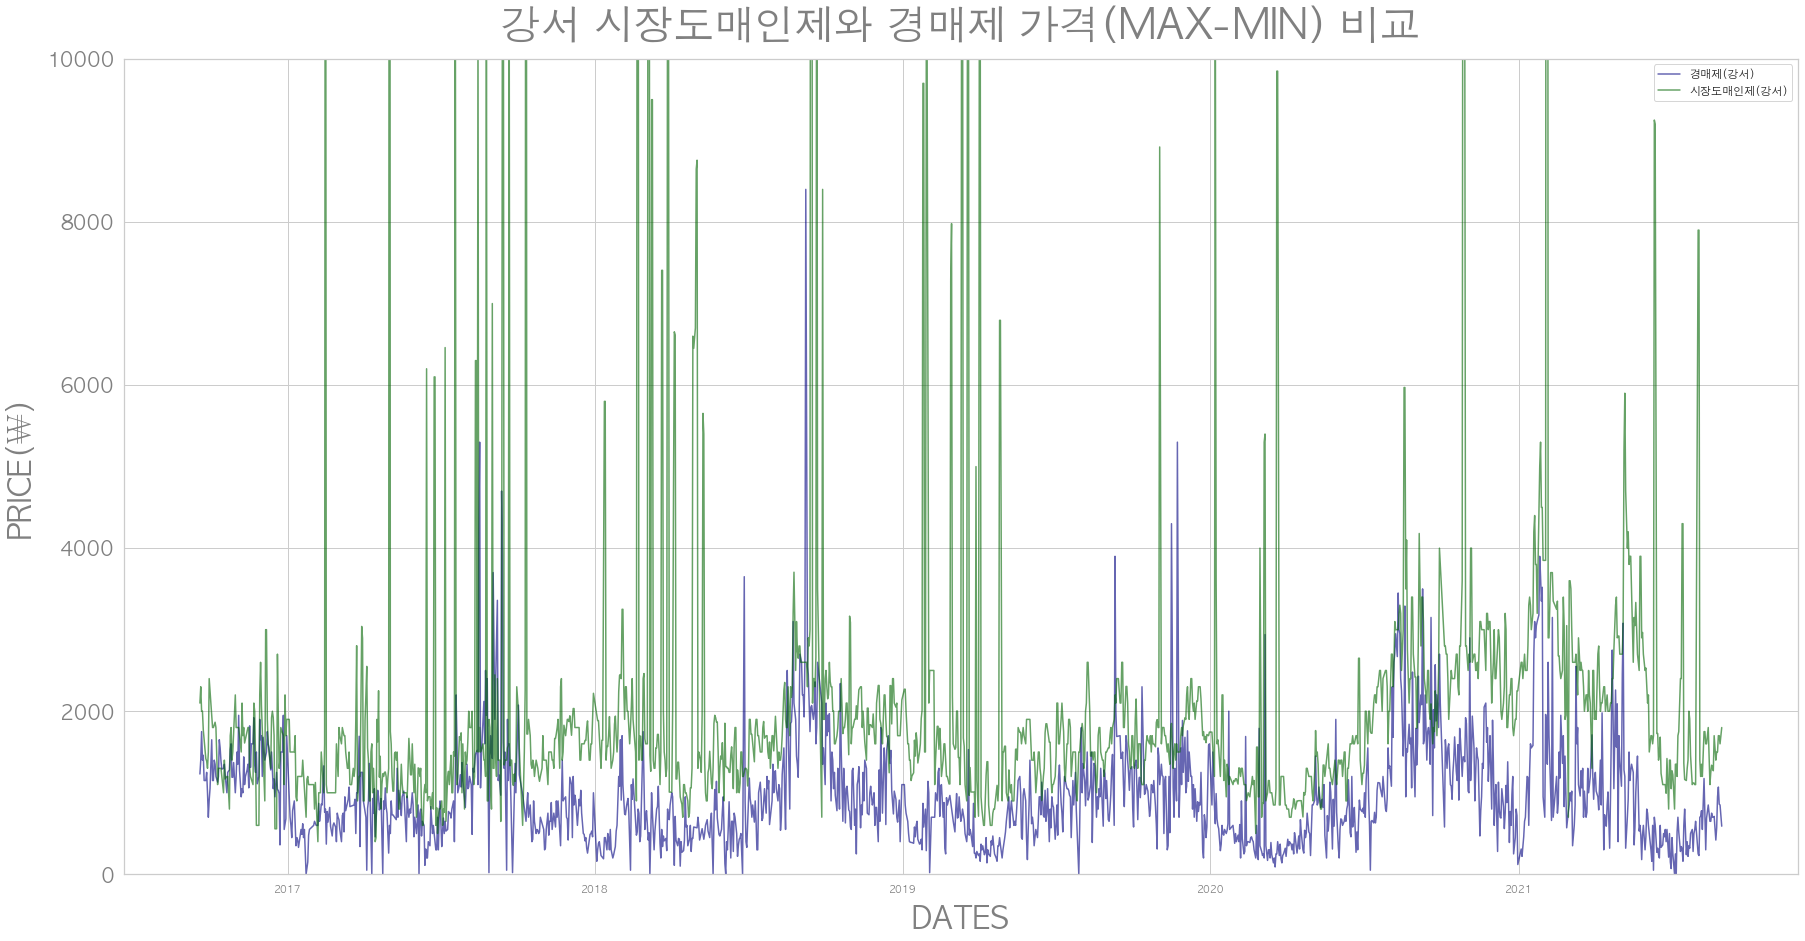

In [91]:
gangseo_g(data_g, data_gs, "P_MAX-MIN", y_lim=True)